# Deep Learning Assignment 2 – Marc Glowienke

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

annots = loadmat('Xtrain.mat')
tf.random.set_seed(123)
np.random.seed(123)

## Analysis of Data Set and Preprocessing

In [2]:
# Extract data from matlab file and add x-series, merge into pandas DataFrame
df_train = pd.DataFrame([np.array(range(len(annots['Xtrain']))),annots['Xtrain'].flatten()])

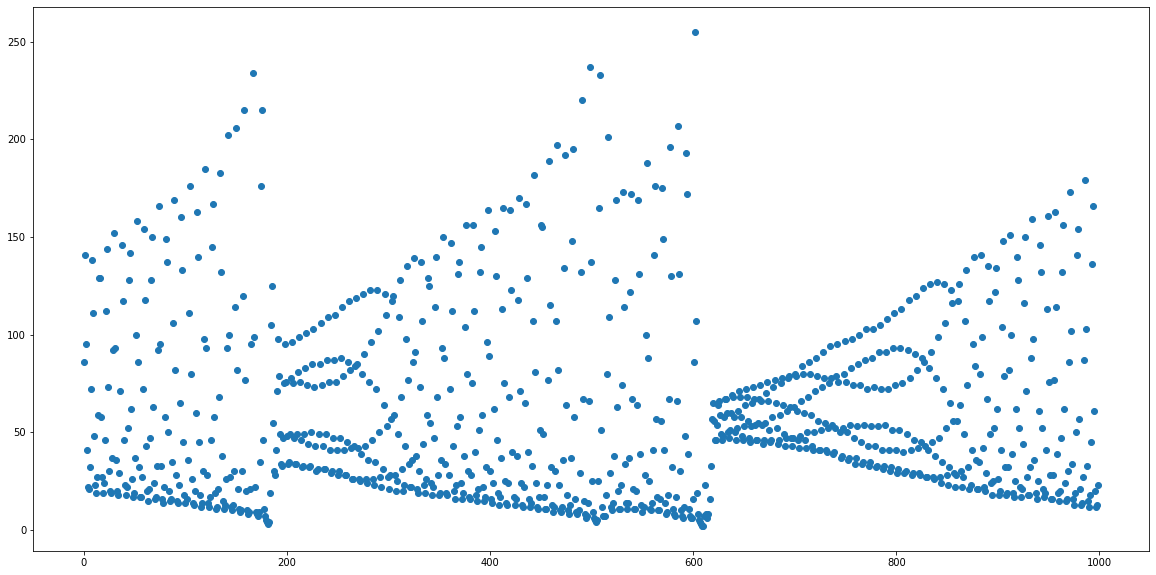

In [3]:
plt.figure(figsize= (20,10))
plt.scatter(df_train.iloc[0,:],df_train.iloc[1,:])
#plt.savefig('series.pdf',bbox_inches='tight')
plt.show()

In [4]:
# Normalize the time series to have mean 0 and std of 1
train_mean = df_train.iloc[1,:].mean()
train_std = df_train.iloc[1,:].std()
df_train = df_train.append((df_train.iloc[1,:]-train_mean)/train_std)

<Figure size 432x288 with 0 Axes>

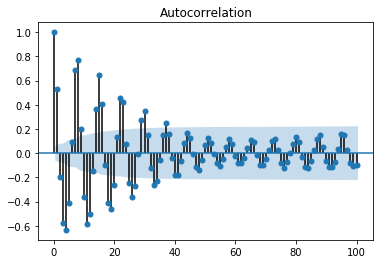

In [5]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure()
plot_acf(df_train.iloc[1,:],lags = 100)
#plt.savefig('ACF.pdf',bbox_inches = 'tight')
plt.show()

In [6]:
# Function to create appropriate supervised data set for prediction,
# we define the history to be used for the target prediction
# the function also gives the possibility to given an end point, 
# so that a part of the dataset can be used as validation part
def make_dataset(df, start, end, history, target_length):
  data = []
  labels = []

  start = start + history
  if end is None:
    end = len(df) - target_length

  for i in range(start, end):
    ind = range(i-history, i)
    # Reshape data
    data.append(np.reshape(df[ind], (history, 1)))
    if target_length == 0:
        labels.append(df[i+target_length])
    else:
        labels.append(df[i:i+target_length])
  return np.array(data), np.array(labels)

In [7]:
def modelling(TRAIN_SPLIT,HISTORY,FUTURE,BATCH,STEPS_PER_EPOCH,EPOCHS,df_train = df_train):
    # Create supervised training set using the complete data set
    x_train, y_train = make_dataset(df_train.iloc[2,:].values, 0, TRAIN_SPLIT, HISTORY,FUTURE)

    # Transform the data to an tensorflow dataset and batch it
    data_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    data_train = data_train.cache().batch(BATCH).repeat()
    
    #Define and train model
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(20, input_shape=x_train.shape[-2:],return_sequences = True),
        tf.keras.layers.LSTM(8),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='sgd', loss='mse')

    #print(model.summary())

    training = model.fit(data_train, epochs=EPOCHS,
                      steps_per_epoch=STEPS_PER_EPOCH,
                 validation_data = data_train, validation_steps = 1000)
    #Evaluation of model
    print("\n Evaluation of model on train set: %.4f" %model.evaluate(data_train, verbose=0, steps=1000))
    
    # Loss and Validation loss plot
    loss = training.history['loss']
    val_loss = training.history['val_loss']
    plt.figure(figsize= (20,10))
    plt.plot(range(len(loss)), loss, 'b', label='Training loss')
    plt.plot(range(len(loss)), val_loss, 'r', label='Validation loss')
    plt.legend()
    #plt.savefig('loss.pdf',bbox_inches = 'tight')
    plt.show()
    
    #Prediction
    # Make dataset to start prediction from, i.e. HISTORY last steps of series
    x_predict = np.array(df_train.iloc[2,-HISTORY:])
    x_predict = x_predict.reshape(1, len(x_predict),1)

    # Create 200 predictions, by adding new prediction to x_predict and deleting the first one
    prediction = np.empty((0,200))
    for iteration in range(200):
        y_hat = model.predict(x_predict,batch_size = 1)
        prediction = np.append(prediction, y_hat)
        
        x_predict = np.append(x_predict,[[[y_hat]]]) #add new element
        x_predict = np.delete(x_predict, 0,0) #delete first element --> keep history size consistent
        x_predict = x_predict.reshape(1, len(x_predict),1)

    # Rescale data
    result = pd.DataFrame([np.array(range(len(annots['Xtrain']),len(prediction)+len(annots['Xtrain'])),dtype='int32')
                       ,prediction*train_std + train_mean])
    # Create plot
    plt.figure(figsize= (20,10))
    plt.scatter(df_train.iloc[0,:],df_train.iloc[1,:],color = 'blue')
    plt.scatter(result.iloc[0,:],result.iloc[1,:],color = 'orange')
    #plt.savefig('prediction.pdf',bbox_inches='tight')
    plt.show()
    
    return result

Train for 500 steps, validate for 1000 steps
Epoch 1/10
500/500 [==============================] - 21s 42ms/step - loss: 0.8570 - val_loss: 0.6637
Epoch 2/10
500/500 [==============================] - 17s 35ms/step - loss: 0.6227 - val_loss: 0.6086
Epoch 3/10
500/500 [==============================] - 18s 36ms/step - loss: 0.5560 - val_loss: 0.5091
Epoch 4/10
500/500 [==============================] - 17s 34ms/step - loss: 0.3453 - val_loss: 0.3549
Epoch 5/10
500/500 [==============================] - 17s 33ms/step - loss: 0.2084 - val_loss: 0.2264
Epoch 6/10
500/500 [==============================] - 16s 33ms/step - loss: 0.1597 - val_loss: 0.2202
Epoch 7/10
500/500 [==============================] - 17s 34ms/step - loss: 0.1229 - val_loss: 0.1390
Epoch 8/10
500/500 [==============================] - 18s 36ms/step - loss: 0.1056 - val_loss: 0.1999
Epoch 9/10
500/500 [==============================] - 17s 34ms/step - loss: 0.0840 - val_loss: 0.1570
Epoch 10/10
500/500 [================

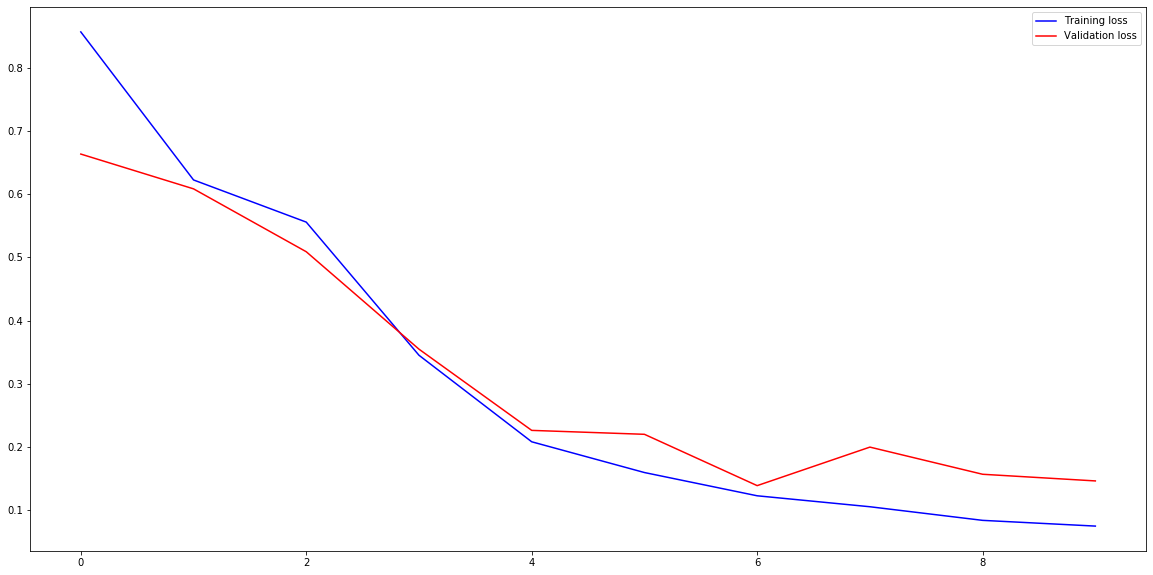

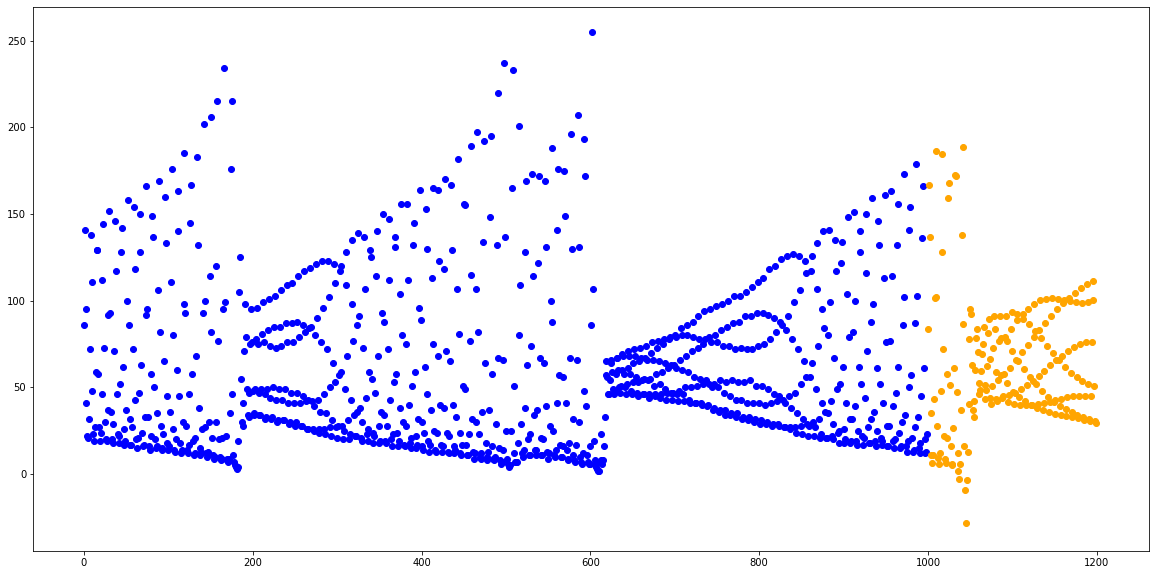

In [8]:
prediction = modelling(TRAIN_SPLIT = None,HISTORY = 20,FUTURE = 0,BATCH = 20,
                    STEPS_PER_EPOCH = 500,EPOCHS = 10,df_train = df_train)
#np.savetxt('prediction.out',prediction,fmt = '%.4f')

## Test Data

In [9]:
test = loadmat('Xtest.mat')
df_test = pd.DataFrame([np.array(range(len(annots['Xtrain']),len(annots['Xtrain'])+len(test['Xtest']))),test['Xtest'].flatten()])

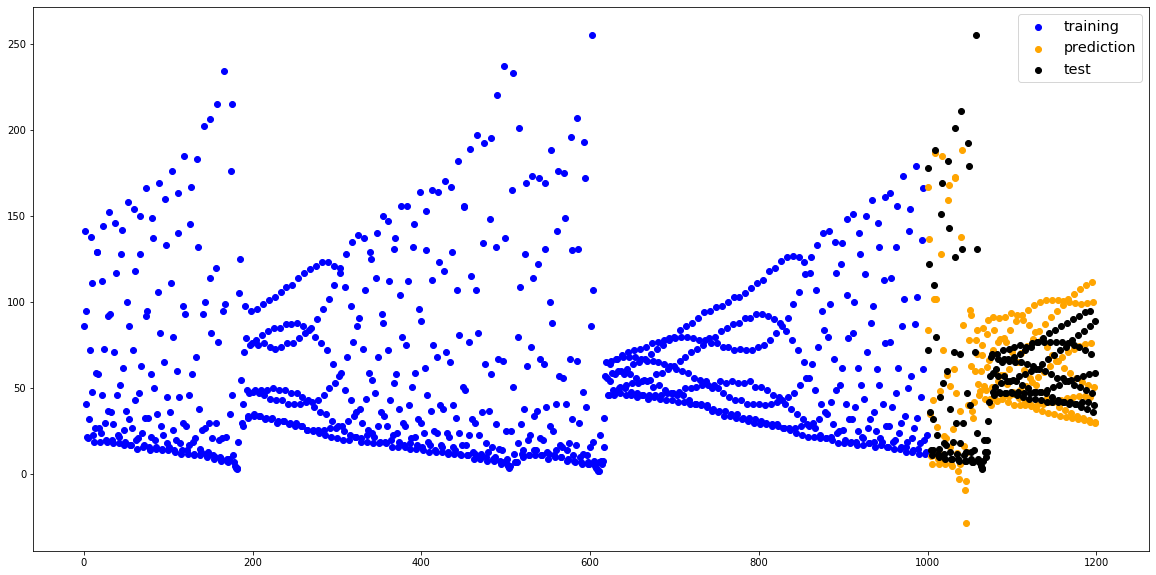

In [22]:
# Create plot, validation in black
plt.figure(figsize= (20,10))
plt.scatter(df_train.iloc[0,:],df_train.iloc[1,:],color = 'blue', label = 'training')
plt.scatter(prediction.iloc[0,:],prediction.iloc[1,:],color = 'orange', label = 'prediction')
plt.scatter(df_test.iloc[0,:],df_test.iloc[1,:],color = 'black', label = 'test')
plt.legend(fontsize='x-large')
#plt.savefig('test.pdf',bbox_inches='tight')
plt.show()

In [13]:
mse = ((prediction.iloc[1,:] - df_test.iloc[1,:])**2).mean()
mae = (np.abs(prediction.iloc[1,:] - df_test.iloc[1,:])).mean()

In [18]:
print("Mean Squared Error: %.4f" %mse,"\n")
print("Mean Absolute Error: %.4f" %mae)

Mean Squared Error: 1452.0717 

Mean Absolute Error: 29.5806
